In [1]:
import sys
sys.path.append('/Users/linggeli/graph_fmri/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from graph_fmri.src.helper import *
from graph_fmri.src.build_graph import *
from graph_fmri.src.graph_models import multi_cgcnn

In [28]:
import os

In [29]:
data_dir = '/Users/linggeli/graph_fmri/clas_data/'
n_coef = 16

In [30]:
brain_regions = np.genfromtxt(os.path.join(data_dir, 'brain_regions.csv'), dtype=int, delimiter=',')[:40] - 1
p_values = np.genfromtxt(os.path.join(data_dir, 'p_values.csv'), delimiter=',')[:40]
X = np.load(os.path.join(data_dir, 'features_259subjects_filtered.npy'))[:, brain_regions, :n_coef]
y = np.load(os.path.join(data_dir, 'labels_259subjects.npy'))

In [34]:
A_spatial = spatial_distance_graph(os.path.join(data_dir, 'adj_matrix.csv'), brain_regions, 70)

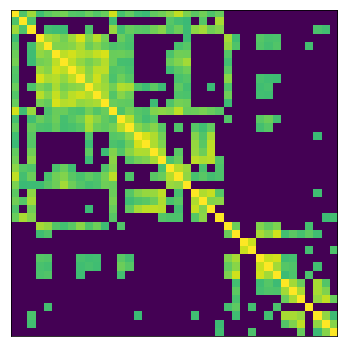

In [35]:
plt.figure(figsize=(6, 6))
plt.imshow(A_spatial)
plt.xticks([])
plt.yticks([])
plt.show()

In [36]:
A_spatial_mask = mask_connections(A_spatial, 50)

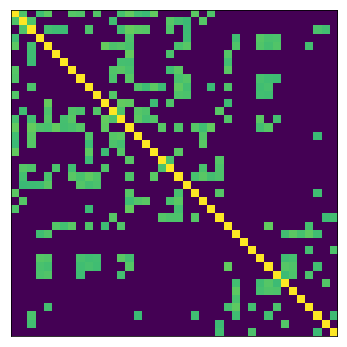

In [37]:
plt.figure(figsize=(6, 6))
plt.imshow(A_spatial_mask)
plt.xticks([])
plt.yticks([])
plt.show()

In [20]:
A_spatial_cut = cut_connections(A_spatial, p_values, 10)

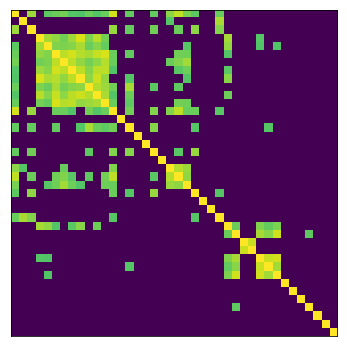

In [21]:
plt.figure(figsize=(6, 6))
plt.imshow(A_spatial_cut)
plt.xticks([])
plt.yticks([])
plt.show()

In [13]:
A_random = random_graph(40, 80)

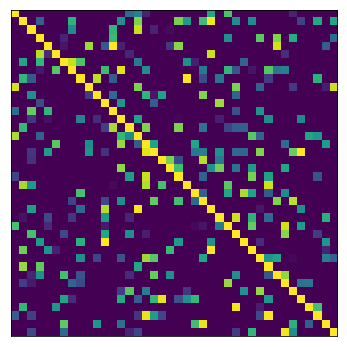

In [14]:
plt.figure(figsize=(6, 6))
plt.imshow(A_random)
plt.xticks([])
plt.yticks([])
plt.show()

**Test different graphs**

In [15]:
X_train, y_train, X_val, y_val = prepare_data(X, y, 0.7)

In [22]:
L, X_train_graph, X_val_graph = structure_data(A_spatial_cut, X_train, X_val)

Layer 0: M_0 = |V| = 128 nodes (88 added),|E| = 122 edges
Layer 1: M_1 = |V| = 64 nodes (38 added),|E| = 48 edges
Layer 2: M_2 = |V| = 32 nodes (13 added),|E| = 17 edges
Layer 3: M_3 = |V| = 16 nodes (0 added),|E| = 6 edges


In [23]:
params = graph_model_params(n_filter=20, dense_size=20, 
                            n_graph=n_coef, keep_prob=0.9,
                            epochs=10, batch_size=20, 
                            n_train=X_train.shape[0], verbose=False)

In [24]:
model = multi_cgcnn(L, **params)

NN architecture
  input: M_0 = 128
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 128 * 20 / 2 = 1280
    weights: F_0 * F_1 * K_1 = 1 * 20 * 10 = 200
    biases: F_1 = 20
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 64 * 20 / 4 = 320
    weights: F_1 * F_2 * K_2 = 20 * 20 * 10 = 4000
    biases: F_2 = 20
  layer 3: fc1
    representation: M_3 = 20
    weights: M_2 * M_3 = 320 * 20 = 6400
    biases: M_3 = 20
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 20 * 2 = 40
    biases: M_4 = 2


In [26]:
accuracy, loss, t_step = model.fit(X_train_graph, y_train, X_val_graph, y_val)

step 362 / 362 (epoch 9.99 / 10):
  learning_rate = 6.30e-04, loss_average = 7.91e-01
  validation accuracy: 70.42 (219 / 311), f1 (weighted): 70.30, loss: 8.26e-01
  time: 286s (wall 96s)
validation accuracy: peak = 70.42, mean = 70.42
